# RNN: Next-word predictor

## Objectives
- Building a __next word predictor__, given a sequence of words
- We would try to __predict__ the next __10 words__ for each given input of words
- Find ways to __evaluate__ generated sequence of words (how meaningful / creative), using __seed_texts__ as benchmark

## Some Background Research

### Common RNN models for text prediction:
1. __Vanilla RNN__: The simplest type of RNN, which uses a single layer of neurons to process input data.
2. __Long Short-Term Memory (LSTM)__: A type of RNN that is designed to avoid the vanishing gradient problem, which can occur when training RNNs on long sequences of data.
3. __Gated Recurrent Unit (GRU__): A type of RNN that is similar to LSTM but has fewer parameters, making it faster to train.

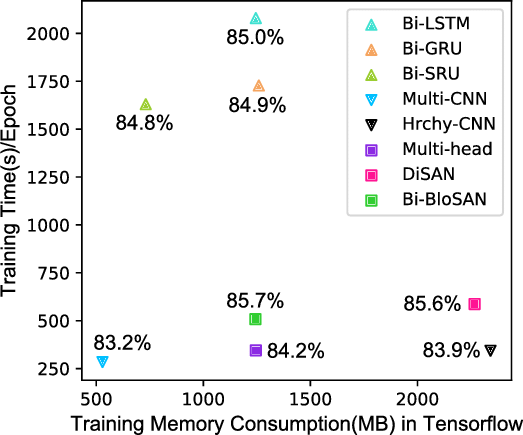

_A comparison of Bi-BloSAN and other RNN/CNN/SAN in terms of training time, training memory consumption and test accuracy on SNLI (Bowman et al., 2015). The details of all the models are provided in Section 4._
### Potential ways to evaluate text generation:
- __N-gram overlap metrics__ - These metrics measure the similarity between the generated text and one or more reference texts by counting the number of matching n-grams (sequences of n words). Examples of these metrics are BLEU, ROUGE, and METEOR.
- __Embedding-based metrics__ - similarity between the generated text and the reference texts by comparing their vector representations
- __Learned metrics__ -  Examples of these metrics are RUBER, BARTScore, and GEM.

## Loading Necessary Libraries

In [1]:
#Numpy, pandas, seaborn, matplotlib
import numpy as np
from numpy import asarray
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

#Tensorflow / Keras
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, LSTM, Embedding,Dropout, Activation,GRU
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras import initializers, regularizers, constraints,optimizers, layers
from keras.layers import Dense, Input, Flatten, Dropout,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras_nlp.metrics import Perplexity
#from tokenizers import ByteLevelBPETokenizer
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import Adam, RMSprop

## NTLK library
from nltk.translate.meteor_score import meteor_score

## Textstat library
import textstat

#import visualkeras

Using TensorFlow backend


C:\Users\wilfr\AppData\Local\Temp\ipykernel_21416\1807635060.py:31: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth configuration for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Proceed with other TensorFlow operations here
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load Dataset

In [307]:
# Read data.

data = pd.read_csv('Datasets/train.csv')

print(data)

# Convert data to a list.
data = list(data.Quotes.values)
print(f'There are {len(data)} quotes in this dataset.')
print(data[:5])


                                                Quotes
0    Embrace the beauty of every sunrise; it's a fr...
1    Embrace challenges; they are the stepping ston...
2    Embrace the rhythm of life and let it dance th...
3    Embrace kindness, for it has the power to chan...
4    Embrace the journey, for it leads to the desti...
..                                                 ...
995  With an open heart, welcome the opportunities ...
996  This morning, let your laughter be the music t...
997  In the serenity of this morning, find the powe...
998  This morning, let your actions be a testament ...
999  With each sunrise, this morning offers the pro...

[1000 rows x 1 columns]
There are 1000 quotes in this dataset.
["Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.", 'Embrace challenges; they are the stepping stones to your greatest victories.', 'Embrace the rhythm of life and let it dance through your soul.', 'Embrace kindness, for it has the power

## Looking at Quote length distribution
- this could also guide us in determining an optimal __input sequence length__ of our model
- currently, it seems like most of the __Quotes fall below 20 words__

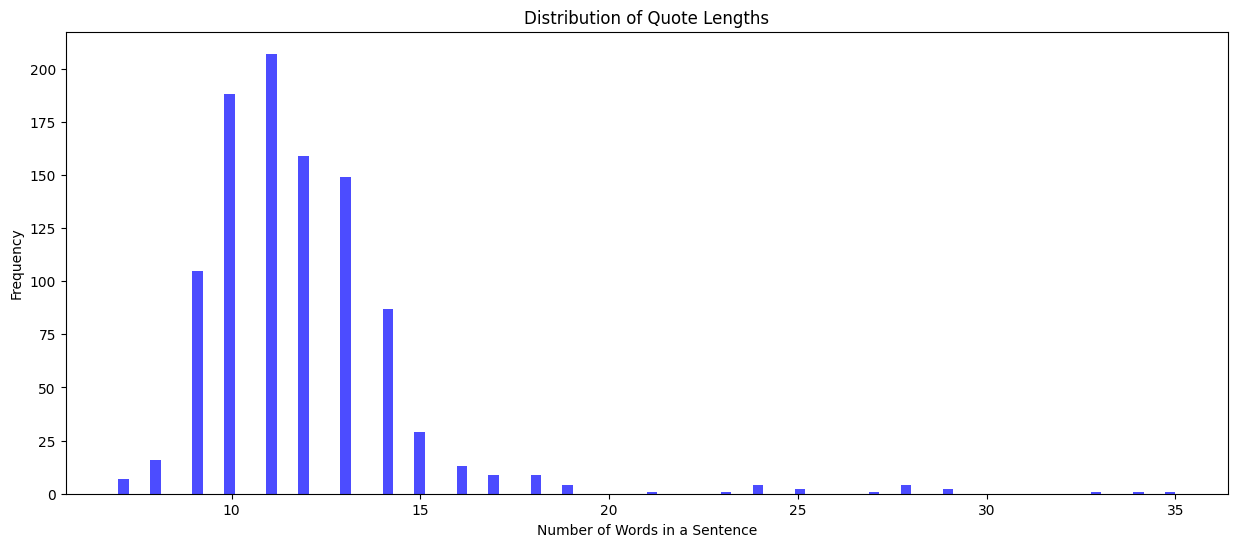

In [308]:
import matplotlib.pyplot as plt

# Assuming `data` is a list of strings (text data)
text_lengths = [len(sentence.split()) for sentence in data]

# Plotting the histogram
plt.figure(figsize=(15,6))
plt.hist(text_lengths, bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Quote Lengths')
plt.xlabel('Number of Words in a Sentence')
plt.ylabel('Frequency')
plt.show()

## Removing unwanted characters / words
### Unwanted Characters
- We can safely discard __punctuations__ like (" " and .), no help in prediction of model
- Remove special characters / symbols

### Unwanted Words

- __Stop Words__: Common stop words such as “a,” “an,” “the,” “is,” “in,” and other frequently occurring words that do not carry significant meaning or predictive power.
- __Irrelevant Words__ : Identify and remove specific words that are not relevant to the prediction task or domain. For example, if you are predicting movie genres, words like “movie” or “film” may not provide helpful information.

In [10]:
# # Create a translation table
# translation_table = str.maketrans({u'\xa0': '', '\u200a': '', '"': '', '.': ''})

# # Apply the translation table to each element in the list
# data = [x.translate(translation_table) for x in data]

In [309]:
data

["Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.",
 'Embrace challenges; they are the stepping stones to your greatest victories.',
 'Embrace the rhythm of life and let it dance through your soul.',
 'Embrace kindness, for it has the power to change the world one heart at a time.',
 'Embrace the journey, for it leads to the destination of your dreams.',
 'Embrace your uniqueness, for it is the fingerprint of your soul on the universe.',
 'Embrace the present moment, for it is the only one that truly exists.',
 'Embrace your fears, for they hold the key to unlocking your true potential.',
 'Embrace gratitude, and watch how it multiplies the blessings in your life.',
 'Embrace the rain, for it nourishes the seeds of your future success.',
 'Embrace the whispers of your heart; they carry the wisdom of the universe.',
 'Embrace laughter, for it is the music of a joyful heart.',
 'Embrace the power of forgiveness, for it sets you free from the chains 

## Tokenization
- for our case, we could try __retaining punctuations like " ' " , " ; " and " , " since they may carry certain information/ sentence structure related info__
- we can also __visualize__ most __common words__ 
<!-- - to ensure __those punctuations__ are treated as seperate tokens, we would have to __add a space before__ a comma for example ",lol" => "," and "lol" -->

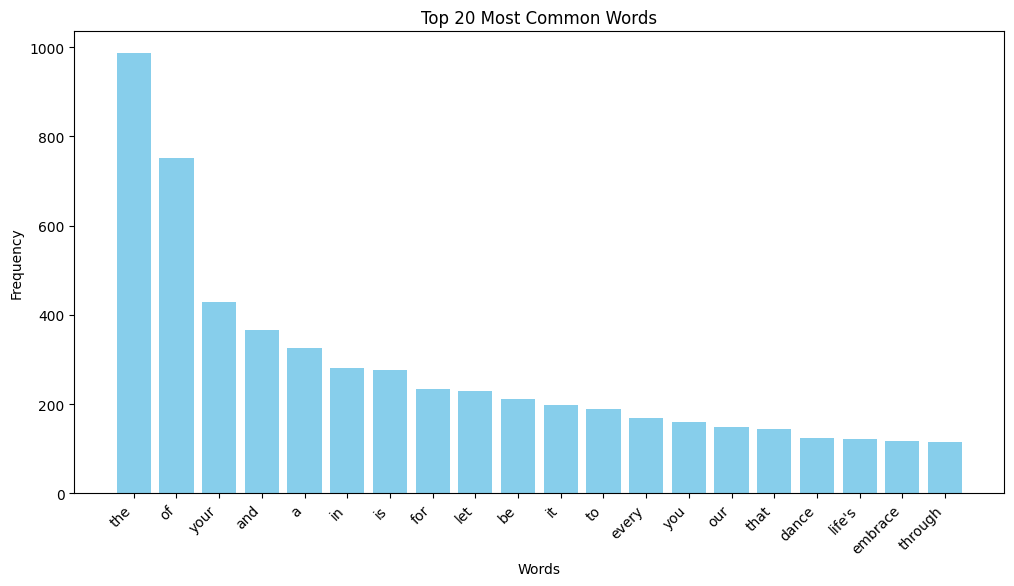

{'the': 1, 'of': 2, 'your': 3, 'and': 4, 'a': 5, 'in': 6, 'is': 7, 'for': 8, 'let': 9, 'be': 10, 'it': 11, 'to': 12, 'every': 13, 'you': 14, 'our': 15, 'that': 16, 'dance': 17, "life's": 18, 'embrace': 19, 'through': 20, 'this': 21, 'with': 22, 'believe': 23, 'are': 24, 'radiate': 25, 'yourself,': 26, 'heart': 27, 'morning,': 28, 'will': 29, "planet's": 30, 'they': 31, 'love': 32, 'life': 33, "singapore's": 34, 'symphony': 35, 'we': 36, 'power': 37, 'from': 38, 'kindness': 39, 'find': 40, 'dreams': 41, 'soul': 42, 'world': 43, 'act': 44, 'light': 45, 'singapore,': 46, 'planet': 47, 'way': 48, 'beauty': 49, 'journey': 50, 'nature': 51, 'colors': 52, 'strength': 53, 'whispers': 54, 'canvas': 55, 'joy': 56, 'gratitude': 57, 'where': 58, 'spirit': 59, 'true': 60, 'beacon': 61, 'towards': 62, 'hold': 63, 'potential': 64, 'hearts': 65, 'testament': 66, 'morning': 67, 'future': 68, 'new': 69, 'heartbeat': 70, 'actions': 71, 'promise': 72, 'force': 73, 'others': 74, 'step': 75, 'compass': 76, 

In [310]:

# Tokenisation.



# Instantiate a Tokenizer object with custom filters
tokenizer = Tokenizer(filters='!"#$%&()*+-./:<=>?@[\\]^_`{|}~\t\n')

# # Replace commas and semicolons with space + punctuation
# data_with_spaces = [text.replace(",", " ,").replace(";", " ;") for text in data]

tokenizer.fit_on_texts(data)

# Calculate the total number of words
total_words = len(tokenizer.word_index) + 1  # Because index 0 is reserved for padding.

# Get the word index from the tokenizer
word_index = tokenizer.word_index

# Calculate word frequencies
word_frequencies = {word: tokenizer.word_counts[word] for word in word_index}

# Get the most common words and their counts
top_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20]

# Extract words and counts for plotting
words, counts = zip(*top_words)

# Plot the most common words
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

print(word_index)
print("words:", total_words)

In [8]:
# Under the Tokenizer object, you can convert texts to sequences of integers.
# Be careful of the indexing of your data list, and how you use the ".texts_to_sequences" method.

print(data[101])
print(tokenizer.texts_to_sequences([data[0]])[0])
print()

print(data[102])
print(tokenizer.texts_to_sequences([data[1]])[0])
print()

print(data[103])
print(tokenizer.texts_to_sequences([data[2]])[0]) #There is this extra [0] at the end, because the output is a list of list.
print()

Radiate kindness, for it has the power to transform hearts and minds.
[19, 1, 49, 2, 13, 765, 421, 5, 173, 550, 12, 99, 3, 43, 22, 56]

Radiate love, for it is the most powerful force in the universe.
[19, 766, 31, 24, 1, 422, 551, 12, 3, 423, 767]

Radiate gratitude, and you'll attract more blessings into your life.
[19, 1, 100, 2, 33, 4, 9, 11, 17, 20, 3, 42]



## Text Vectorization

In [311]:
# Convert quotes from text to integer
input_sequence = []

for datapoint in data:
    token_list = tokenizer.texts_to_sequences([datapoint])[0] # Again, this extra [0] is because the output
                                                              # is a list of list.
    input_sequence.append(token_list)

print(f'Total number of quotes: {len(input_sequence)}')


Total number of quotes: 1000


In [312]:

input_sequences = []
for line in data:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  10886


## Generating more Input-Output pairs

In [211]:
# input_sequence_sorted = sorted(input_sequence, key=len)
# input_sequence_sorted

### Function: Generate I/O pairs 

In [313]:
# def generate_input_output_pairs(input_sequence, n):
#     input_output_pair = set()  # Use a set to store unique pairs

#     for datapoint in input_sequence:
#         # if len(datapoint) >= n:
#             for i in range(len(datapoint) - (n - 1)):
#                 pair = tuple(datapoint[i:i + n])
#                 input_output_pair.add(pair)

#     return list(input_output_pair)  # Convert set back to a list for further processing


def generate_input_output_pairs(input_sequence, n):
    input_output_pair = []

    for datapoint in input_sequence:
        for i in range(len(datapoint) - (n - 1)):
            pair = tuple(datapoint[i:i + n])
            input_output_pair.append(pair)

    return input_output_pair  # Return the list without converting to a set


### Generating and Padding Input Output Pairs
- here, we iterate through till the __max sequence length of our data (35)__, considering every possible __list of 2 to n words__, where n is the sequence length (if the length of each quote exceeds n, we stop producing pairs from that quote)
<!-- - i decided to try padding up till __20 words__, as since we are mainly predicting next __10 words__ / shorter quotes,however,while saving training time, we may lose information on the longer input sequences > 20 words -->

In [322]:
input_output_pairs = []


for i in range(2, 35, 1):  # Max no. of word length in our dataset
    pairs = generate_input_output_pairs(input_sequence, i)
    input_output_pairs.extend(pairs)
    max_sequence_len = max([len(x) for x in input_output_pairs]) # This is to get the longest sequence of texts. 


# Pad all input-output pairs to the same length
input_output_pairs_padded = np.array(pad_sequences(input_output_pairs, maxlen=max_sequence_len, padding='pre'))

print(input_output_pairs_padded)
print(max_sequence_len)


[[   0    0    0 ...    0   19    1]
 [   0    0    0 ...    0    1   49]
 [   0    0    0 ...    0   49    2]
 ...
 [  13   44    2 ...    2  224    4]
 [  44    2   32 ...  224    4 1074]
 [  13  106  125 ...  670    3   48]]
34


### Double check for duplicated input-out pairs (unique)

In [18]:

# Convert each list to a tuple and use set to find duplicates
duplicates = [list(item) for item in set(tuple(lst) for lst in input_output_pairs) if input_output_pairs.count(list(item)) > 1]

# Print duplicates
print("Exact duplicates within each list:")
i = 0
for duplicate in duplicates:
    print(duplicate)
    i+=1
print(i)

Exact duplicates within each list:
0


## Prepare features and labels

In [323]:
# Now that we have an array, let us slice the last word as the output.
# The preceding words are the input.

X = input_output_pairs_padded[:,:-1]
y = input_output_pairs_padded[:,-1]
print(X)
print("")
print(y)

[[  0   0   0 ...   0   0  19]
 [  0   0   0 ...   0   0   1]
 [  0   0   0 ...   0   0  49]
 ...
 [ 13  44   2 ...  78   2 224]
 [ 44   2  32 ...   2 224   4]
 [ 13 106 125 ...  16 670   3]]

[   1   49    2 ...    4 1074   48]


### Splitting to Validation and Train sets
- we use __train_test_split__ for validation data (20%), random state to allow reproducibility

In [324]:
from sklearn.model_selection import train_test_split


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (48247, 33)
y_train shape: (48247,)
X_val shape: (20678, 33)
y_val shape: (20678,)


### One-hot encoding

In [325]:
from tensorflow.keras import utils
y_train = utils.to_categorical(y_train, num_classes=total_words)
y_val = utils.to_categorical(y_val, num_classes=total_words)
print(y_train)
print(y_val)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [326]:


print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(48247, 33)
(48247, 1384)
(20678, 33)
(20678, 1384)


# Helper Functions

## Function: Model Accuracy and Loss

In [251]:
def plot_graphs_acc(history,title):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel('Accuracies')
    plt.title(title)
    plt.show()

def plot_graphs_loss(history,title):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()


## Function: Predict Next N words (with randomness)

### Higher Temperature (e.g., > 1.0):

Increases randomness.

Softens the probability distribution, making less probable words more likely to be chosen.

Results in more diverse but potentially less coherent/generated text.

### Lower Temperature (e.g., < 1.0):

Reduces randomness.

Sharpens the probability distribution, making high-probability words more likely to be chosen.

Results in more focused but potentially repetitive/generated text.


#### _Basically adjusts the shape of the probability distribution used to sample the next word._

In [22]:
def predict_next_N_words(model, input_text, N_words=10, input_length=max_sequence_len-1, temperature=1.0):

    generated_text = input_text
    if temperature <= 0:
        return "Temperature should be greater than 0"
    for _ in range(N_words):
        tokens = tokenizer.texts_to_sequences([input_text])[0]
        tokens = pad_sequences([tokens], maxlen=input_length, padding='pre')
        prediction = model.predict(tokens, verbose=0)[0]

        # Adjust temperature for more or less randomness
        prediction = np.log(prediction) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # Sample from the probability distribution with some randomness using multinomial
        predicted_index = np.random.choice(len(prediction), p=prediction)
        predicted_word = tokenizer.index_word.get(predicted_index, '')

        generated_text += " " + predicted_word
        input_text += " " + predicted_word  # Update the input text for the next prediction

    return generated_text






## Function: Test on seed_texts

In [23]:
def test_on_seed_texts(model,N_words = 10,input_length = max_sequence_len-1,temperature=0):
    seed_texts = ['embrace each day',
                'radiate some',
                'believe that',
                "life's actual purpose is",
                'dance through each and every',
                'let your time and energy',
                'every person is',
                'our country Singapore is',
                'planet earth is',
                'morning and evening would make it']
    predicted_text_list = []
    for input_text in seed_texts:
        predicted_text = predict_next_N_words(model,input_text, N_words,input_length,temperature)
        predicted_text_list.append(predicted_text)
        #print(predicted_text)
    
    return predicted_text_list

## Function: METEOR Score computation based on generated texts
- METEOR (Metric for Evaluation of Translation with Explicit ORdering) considers precision, recall, stemming, synonymy, and word order, more on __Quality of generated text__
- our data is sorted nicely for us, with __100 quotes__ corresponding to each of the __10 themes inside seed texts__, which we can use as the __reference texts__
- which we can use a loop to evaluate our __generated sequence__ on the __100 quotes__ under the same theme

In [24]:
def METEOR_score_gen_text(predicted_list, name):
    seed_texts = ['embrace each day',
                'radiate some',
                'believe that',
                "life's actual purpose is",
                'dance through each and every',
                'let your time and energy',
                'every person is',
                'our country Singapore is',
                'planet earth is',
                'morning and evening would make it']
    # Compute METEOR score for each seed text and prediction
    total_meteor_score = 0
    print(f"{name} METEOR scores\n")
    
    for seed_index, seed_text in enumerate(seed_texts):
        # Retrieve the corresponding chunk of 100 quotes for the theme
        start_index = seed_index * 100
        end_index = (seed_index + 1) * 100
        reference_chunk = data[start_index:end_index]
        
        # Tokenize the predicted line and enclose in double quotes
        predicted_tokens = predicted_list[seed_index].lower().split()
        
        # Tokenize reference quotes to lowercase
        reference_tokens = [quote.lower().split() for quote in reference_chunk]
        
        # Compute METEOR score for the theme
        meteor = meteor_score(reference_tokens, predicted_tokens)
        total_meteor_score += meteor
        
        print(f"METEOR Score for '{seed_text}': {round(meteor, 3)}")
    
    # Compute and print the overall METEOR score
    overall_meteor_score = total_meteor_score / len(seed_texts)
    print(f"\nOverall METEOR Score for {name}: {round(overall_meteor_score, 3)}")

## Function: Calcualate Readbility using Textstat
- The FRES (Flesh Reading Ease) test works by counting the number of words, syllables, and sentences in the text.
- It then calculates the average number of words per sentence and the average number of syllables per word. 
- The idea is that shorter words and shorter sentences are easier to read. The higher the score, the easier the text is to understand.



| Score   | Difficulty        |
| ------- | ----------------- |
| 90-100  | Very Easy         |
| 80-89   | Easy              |
| 70-79   | Fairly Easy       |
| 60-69   | Standard          |
| 50-59   | Fairly Difficult  |
| 30-49   | Difficult         |
| 0-29    | Very Confusing    |


_Example Usage_

In [25]:
import textstat

text = "My name is wilfred."

# Flesch Reading Ease score
reading_ease = textstat.flesch_reading_ease(text)           

print(f"Flesch Reading Ease Score: {reading_ease}")


Flesch Reading Ease Score: 92.8


In [47]:
def difficulty_level(reading_ease):
    if 90 <= reading_ease <= 150:
        return "Very Easy"
    elif 80 <= reading_ease <= 89:
        return "Easy"
    elif 70 <= reading_ease <= 79:
        return "Fairly Easy"
    elif 60 <= reading_ease <= 69:
        return "Standard"
    elif 50 <= reading_ease <= 59:
        return "Fairly Difficult"
    elif 30 <= reading_ease <= 49:
        return "Difficult"
    elif 0 <= reading_ease <= 29:
        return "Very Confusing"
    else:
        return "Invalid score"

def readability_score(generated_text):
    scores = 0
    for text in generated_text:
        # Flesch Reading Ease score
        reading_ease = textstat.flesch_reading_ease(text)
        print(f"Text: {text}\nReading score: {reading_ease}\nReading Difficulty: {difficulty_level(reading_ease)}\n")
        scores += reading_ease
    # Get avg score
    average_score = round(scores/len(generated_text),3)

    print(f"Average Readability Score: {average_score}\n Average Reading Difficulty: {difficulty_level(average_score)}")
    

## Function: Perplexity Of Models (based on generated text)
- Perplexity is a standard that evaluates how well a __probability model__ can predict a sample.
- __Lower score__ indicates __better__ generalization performance
- The score would obviously be affected by the __predicted sequence length__, shorter sequences tend to have lower perplexity scores because there are fewer predictions to make, and the language model has fewer opportunities to make mistakes.

#### We would include the __seed_texts__ in calculation, which means __perplexity scores__ reflects more on __how well the model can predict continuation__ of sequences given the context

In [192]:

def calculate_perplexity(generated_texts, language_model, tokenizer, max_sequence_len):
    perplexities = []  # Store perplexity values for each generated text

    for text in generated_texts:
        words = text.split()

        total_log_probability = 0
        total_words = 0

        for i in range(len(words)-1):
            input_sequence = ' '.join(words[:i+1])
            target_word = words[i+1]

            input_sequence = tokenizer.texts_to_sequences([input_sequence])[0]

            if not input_sequence:
                continue  # Skip empty sequences

            input_sequence = pad_sequences([input_sequence], maxlen=max_sequence_len-1, padding='pre')
            probabilities = language_model.predict(input_sequence,verbose=0)[0]

            if target_word in tokenizer.word_index:
                target_index = tokenizer.word_index[target_word]
                total_log_probability += np.log(probabilities[target_index])
                total_words += 1

        # Calculate perplexity for the current generated text
        if total_words > 0:
            perplexity = np.exp(-total_log_probability / total_words)
            perplexities.append(perplexity)
        else:
            perplexities.append(float('inf'))

    return perplexities

## Function: Analyse Perplexity with Plot

In [193]:
def analyze_and_plot_perplexity(generated_texts, model_path, tokenizer, max_sequence_len):
    # Load the language model
    language_model = load_model(model_path)

    # Calculate perplexities
    perplexities = calculate_perplexity(generated_texts, language_model, tokenizer, max_sequence_len)

    # Calculate average perplexity
    average_perplexity = np.mean(perplexities)

    # Plotting the perplexities
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(perplexities) + 1), perplexities, color='skyblue')
    plt.axhline(y=average_perplexity, color='red', linestyle='--', label='Average Perplexity')
    plt.title('Perplexity for Generated Texts')
    plt.xlabel('Generated Texts')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.show()

    print(f"Average Perplexity: {average_perplexity}")
    return average_perplexity

# Modelling

## Training Simple RNN Model
- Starting with __Embedding__ nodes of 128, then __half it for the SimpleRNN nodes__
- Adding a __Dropout of 0.3__ before the output __Dense__ layer
- We can use this as our __baseline model__, since usually, we would expect __LSTMs and GRU__ to perform better


In [158]:
RNN_base= Sequential()
RNN_base.add(Embedding(total_words, 128, input_length=max_sequence_len-1))
RNN_base.add(SimpleRNN(64))
RNN_base.add(Dropout(0.30))
RNN_base.add(Dense(total_words, activation='softmax'))
RNN_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
)
model_checkpoint_RNN = ModelCheckpoint('Models_RNN/RNN_base.h5',save_best_only=True)

history_RNN_base = RNN_base.fit(X_train,y_train, epochs=50,batch_size=128,verbose=1,validation_data=(X_val,y_val),shuffle=True,callbacks=[early_stopping,model_checkpoint_RNN])


Epoch 1/50
431/431 [==============================] - 22s 48ms/step - loss: 5.3646 - accuracy: 0.1143 - val_loss: 4.5587 - val_accuracy: 0.2072
Epoch 2/50
431/431 [==============================] - 20s 47ms/step - loss: 4.0875 - accuracy: 0.2722 - val_loss: 3.5856 - val_accuracy: 0.3300
Epoch 3/50
431/431 [==============================] - 20s 45ms/step - loss: 3.3583 - accuracy: 0.3645 - val_loss: 3.0434 - val_accuracy: 0.4038
Epoch 4/50
431/431 [==============================] - 20s 47ms/step - loss: 2.9108 - accuracy: 0.4191 - val_loss: 2.6608 - val_accuracy: 0.4528
Epoch 5/50
431/431 [==============================] - 20s 46ms/step - loss: 2.5782 - accuracy: 0.4664 - val_loss: 2.3802 - val_accuracy: 0.4990
Epoch 6/50
431/431 [==============================] - 19s 44ms/step - loss: 2.3299 - accuracy: 0.5033 - val_loss: 2.1503 - val_accuracy: 0.5401
Epoch 7/50
431/431 [==============================] - 19s 44ms/step - loss: 2.1283 - accuracy: 0.5373 - val_loss: 1.9678 - val_accuracy:

In [171]:
RNN_base.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 33, 128)           177152    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1384)              89960     
                                                                 
Total params: 279,464
Trainable params: 279,464
Non-trainable params: 0
_________________________________________________________________


## Evaluating On Accuracies and Loss
- we do see quite a nice convergence of both __val and train accuracies__ , although they aren't really considered that high
- accuracies of ~76%

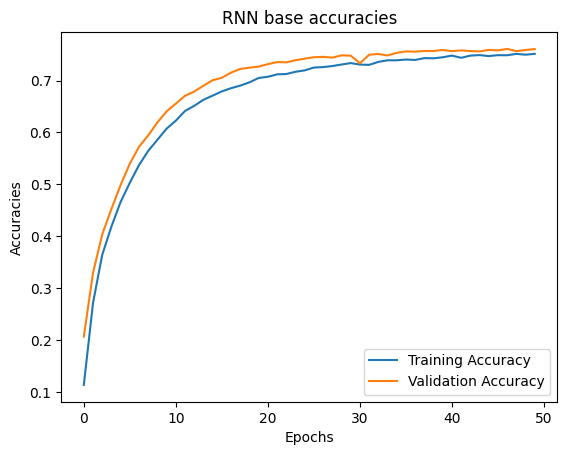

In [159]:
plot_graphs_acc(history_RNN_base,'RNN base accuracies')

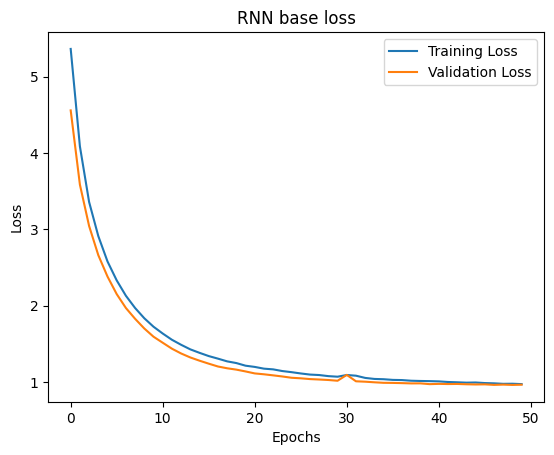

In [160]:
plot_graphs_loss(history_RNN_base,'RNN base loss')

## Test on Seed Texts
- we can try to generate two types of texts, one more "creative" the other more "precise", by adjusting the __temperature__ (>1.0 for creative , <1.0 for more precise)
- some of the generated texts could be gramatically "okay", but __meaningfulness wise__ it's quite bad
- for the more 'creative' texts, we do see more diverse vocab, but they make less sense / bad sentence structure

In [172]:
RNN_base = load_model("Models_RNN/RNN_base.h5")

In [173]:
RNN_pred_precise = test_on_seed_texts(RNN_base,10,max_sequence_len-1,0.2)
RNN_pred_creative = test_on_seed_texts(RNN_base,10,max_sequence_len-1,2.0)


In [174]:
RNN_pred_precise 

['embrace each day with the strokes of our dreams and actions be a',
 'radiate some positivity, for it is the heartbeat of transformation that our',
 'believe that transcends all barriers dance through the melody of change, for',
 "life's actual purpose is a haven of tranquility around you to new heights to",
 'dance through each and every day is a gift to the soul of our planet',
 'let your time and energy is the heartbeat of humanity and joy will follow up',
 'every person is an opportunity for growth and learning vision of tomorrow for',
 'our country Singapore is an investment in your future success our planet holds the',
 'planet earth is a setup for a comeback future of our planet holds',
 'morning and evening would make it is the key to unlocking your true potential to our']

In [175]:
RNN_pred_creative 

['embrace each day is more beautiful connection; in weaving rustle of threads you',
 'radiate some growth; it is the canvas, your reality spread wide open',
 'believe that reverberates in your heart, to simplicity, mirror the whisper of',
 "life's actual purpose is rich are infectious, spreading intuition, and industry that light in",
 "dance through each and every carries gratitude ridges' skyline, ideas rain meaningful all investment true",
 'let your time and energy it heal shine, for it change the symphony that lesson',
 'every person is rich sets you free from the tall, a guiding light',
 'our country Singapore is an holds the night every stone unity and testament to',
 'planet earth is preserved with extraordinary rustle of survival sowing promise of love',
 'morning and evening would make it is no utmost you freedom watch what and mend souls']

## Evaluate METEOR scores
- We do see __overall METEOR__ score being higher for the "precise" texts compared to "creative"
- This is expected since using higher temperatures introduce more randomness, resulting in more diverse but potentially less coherent predictions

In [187]:
METEOR_score_gen_text(RNN_pred_precise,'RNN_pred_precise')
print("")
METEOR_score_gen_text(RNN_pred_creative,'RNN_pred_creative')

RNN_pred_precise METEOR scores

METEOR Score for 'embrace each day': 0.216
METEOR Score for 'radiate some': 0.744
METEOR Score for 'believe that': 0.18
METEOR Score for 'life's actual purpose is': 0.329
METEOR Score for 'dance through each and every': 0.487
METEOR Score for 'let your time and energy': 0.406
METEOR Score for 'every person is': 0.616
METEOR Score for 'our country Singapore is': 0.144
METEOR Score for 'planet earth is': 0.393
METEOR Score for 'morning and evening would make it': 0.237

Overall METEOR Score for RNN_pred_precise: 0.375

RNN_pred_creative METEOR scores

METEOR Score for 'embrace each day': 0.165
METEOR Score for 'radiate some': 0.437
METEOR Score for 'believe that': 0.284
METEOR Score for 'life's actual purpose is': 0.259
METEOR Score for 'dance through each and every': 0.307
METEOR Score for 'let your time and energy': 0.457
METEOR Score for 'every person is': 0.306
METEOR Score for 'our country Singapore is': 0.269
METEOR Score for 'planet earth is': 0.243

## Perplexity Scores


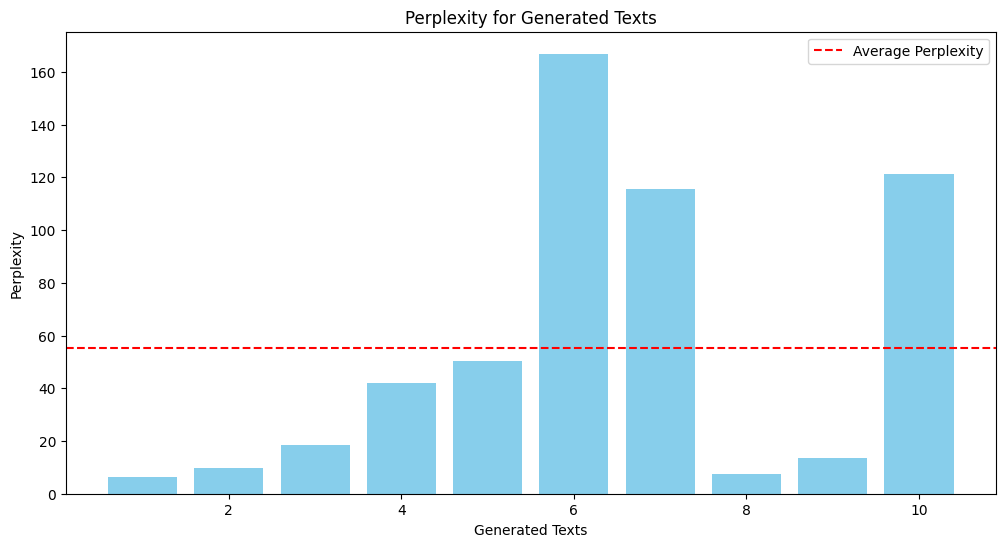

Average Perplexity: 55.145386237453536


In [194]:
RNN_pred= test_on_seed_texts(RNN_base,10,max_sequence_len-1,1.0) #generated text "normal" , temperature set as 1.0
model_path_RNN = "Models_RNN/GRU_base.h5" 

average_perplexity_RNN = analyze_and_plot_perplexity(RNN_pred, model_path_RNN, tokenizer, max_sequence_len)

### Results
- Based on the __plot__, we do see that the model __stuggles__ to predict mainly for __seed_text 6__, (let your time and energy...) having the __highest perplexity score of ~160+__ , which we can also tell by reading the generated text
- Average Perplexity of __55.15__

In [190]:
for i,gen_text in enumerate(RNN_pred):
    print(f"{i+1}: {gen_text}")

1: embrace each day brings new opportunities to shine bright future success our planet
2: radiate some kindness, and become a beacon of light in the world
3: believe that from bitterness and resentment, a path towards healing and inner
4: life's actual purpose is a gesture of hope and enlightenment opportunities and possibilities that
5: dance through each and every vitality and transformation that our planet encourages and compassion you
6: let your time and energy is the realization of your heart lead a day is
7: every person is a garden of kindness we plant its burdens be the
8: our country Singapore is rich with the brushstrokes of survival artistry of our planet
9: planet earth is a leap of faith is a step towards a joyful
10: morning and evening would make it is the foundation of every action and decision shaping the


# Training GRU Model
- we'll adopt the similar configurations applied to the __Base SimpleRNN Model__
- i realised __GRU__ model often trains at a way faster rate compared to __SimpleRNN__ (~4 times faster), while also have less parameters

In [330]:

GRU_base= Sequential()
GRU_base.add(Embedding(total_words, 128, input_length=max_sequence_len-1))  # Corrected input_length
GRU_base.add(GRU(64))  # Replace SimpleRNN with GRU
GRU_base.add(Dropout(0.30))
GRU_base.add(Dense(total_words, activation='softmax'))
GRU_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
)

model_checkpoint_GRU = ModelCheckpoint('Models_RNN/GRU_base.h5', save_best_only=True)

history_GRU_base = GRU_base.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(X_val, y_val), shuffle=True, callbacks=[early_stopping, model_checkpoint_GRU])

# Print the model summary
GRU_base.summary()

Epoch 1/50
754/754 [==============================] - 7s 8ms/step - loss: 5.1303 - accuracy: 0.1377 - val_loss: 4.2969 - val_accuracy: 0.2366
Epoch 2/50
754/754 [==============================] - 6s 8ms/step - loss: 3.8672 - accuracy: 0.2938 - val_loss: 3.3838 - val_accuracy: 0.3593
Epoch 3/50
754/754 [==============================] - 6s 8ms/step - loss: 3.1390 - accuracy: 0.3881 - val_loss: 2.7967 - val_accuracy: 0.4398
Epoch 4/50
754/754 [==============================] - 6s 7ms/step - loss: 2.6344 - accuracy: 0.4613 - val_loss: 2.3775 - val_accuracy: 0.5084
Epoch 5/50
754/754 [==============================] - 6s 8ms/step - loss: 2.2779 - accuracy: 0.5170 - val_loss: 2.0760 - val_accuracy: 0.5637
Epoch 6/50
754/754 [==============================] - 6s 7ms/step - loss: 2.0129 - accuracy: 0.5617 - val_loss: 1.8509 - val_accuracy: 0.6036
Epoch 7/50
754/754 [==============================] - 6s 7ms/step - loss: 1.8267 - accuracy: 0.5917 - val_loss: 1.6785 - val_accuracy: 0.6275
Epoch 

## Train and Validation Accuracies/Loss

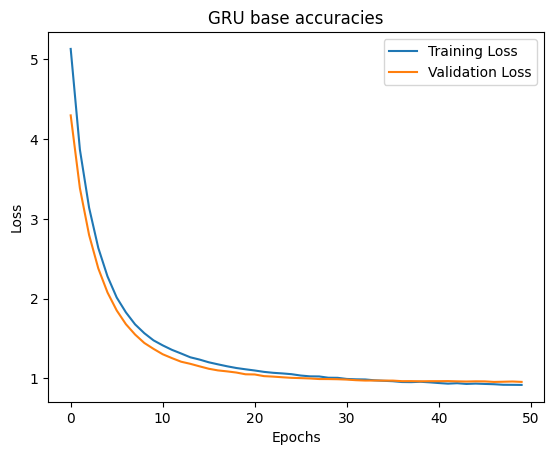

In [331]:
plot_graphs_loss(history_GRU_base,'GRU base accuracies')

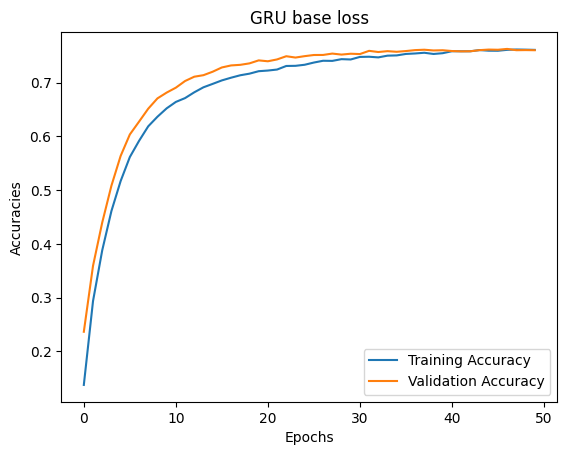

In [332]:
plot_graphs_acc(history_GRU_base,'GRU base loss')

## Test on Seed Texts
- we can try to generate two types of texts, one more "creative" the other more "precise", by adjusting the __temperature__ 


In [333]:
GRU_base = load_model("Models_RNN/GRU_base.h5")

### "Creative" and "Precise" generated texts
- we can roughly set __temperature__ as 0.2 for more precise texts
- while setting __temperature__ as 1.5 for more creative texts

In [334]:
GRU_pred_precise = test_on_seed_texts(GRU_base,10,max_sequence_len-1,0.2)

GRU_pred_creative = test_on_seed_texts(GRU_base,10,max_sequence_len-1,1.5)



In [335]:
GRU_pred_precise

['embrace each day is a beacon of hope for others to cherish and',
 'radiate some determination, and let it be the driving force of your',
 'believe that heals old wounds wounds and mend hearts and restore faith',
 "life's actual purpose is a lesson to be embraced to the world around you",
 'dance through each and every day is a gift from the universe, a reminder of',
 'let your time and energy adaptation diversity create a harmonious symphony of joy in the',
 'every person is a leap of faith is a step, a step towards',
 'our country Singapore is where values and kindness that resonates with the world around',
 'planet earth is a promise to safeguard the future of our planet holds',
 "morning and evening would make it is the legacy of love for our planet's future of"]

In [336]:
GRU_pred_creative

['embrace each day is a pledge to tread lightly on the heart to',
 'radiate some resilience, and let it be the bedrock of your strength',
 'believe that forests are the sweetest bloom into solace in your stillness',
 "life's actual purpose is carry it plays that strength a darkest that possibilities it",
 'dance through each and every path is an leap of hope for a brighter future',
 'let your time and energy worthy heart; reaching for you stars of every morning, let',
 'every person is an opportunity for true strength and diversity create reality, of',
 'our country Singapore is determined break to illuminates the path, providing strength, hope, and',
 'planet earth is the beacon that soothes and influence your world with brightness',
 'morning and evening would make it day, leaving a warmth to grudges a well lived life']

## Readibility Scores
_this is just a rough estimate, not fully accurate_

In [337]:
readability_score(GRU_pred_precise)

Text: embrace each day is a beacon of hope for others to cherish and
Reading score: 83.66
Reading Difficulty: Easy

Text: radiate some determination, and let it be the driving force of your
Reading score: 59.3
Reading Difficulty: Invalid score

Text: believe that heals old wounds wounds and mend hearts and restore faith
Reading score: 93.14
Reading Difficulty: Very Easy

Text: life's actual purpose is a lesson to be embraced to the world around you
Reading score: 74.19
Reading Difficulty: Fairly Easy

Text: dance through each and every day is a gift from the universe, a reminder of
Reading score: 90.09
Reading Difficulty: Very Easy

Text: let your time and energy adaptation diversity create a harmonious symphony of joy in the
Reading score: 39.33
Reading Difficulty: Difficult

Text: every person is a leap of faith is a step, a step towards
Reading score: 92.12
Reading Difficulty: Very Easy

Text: our country Singapore is where values and kindness that resonates with the world around
Re

In [338]:
readability_score(GRU_pred_creative)

Text: embrace each day is a pledge to tread lightly on the heart to
Reading score: 92.12
Reading Difficulty: Very Easy

Text: radiate some resilience, and let it be the bedrock of your strength
Reading score: 84.68
Reading Difficulty: Easy

Text: believe that forests are the sweetest bloom into solace in your stillness
Reading score: 76.22
Reading Difficulty: Fairly Easy

Text: life's actual purpose is carry it plays that strength a darkest that possibilities it
Reading score: 57.27
Reading Difficulty: Fairly Difficult

Text: dance through each and every path is an leap of hope for a brighter future
Reading score: 98.55
Reading Difficulty: Very Easy

Text: let your time and energy worthy heart; reaching for you stars of every morning, let
Reading score: 73.17
Reading Difficulty: Fairly Easy

Text: every person is an opportunity for true strength and diversity create reality, of
Reading score: 24.44
Reading Difficulty: Very Confusing

Text: our country Singapore is determined break to i

## METEOR Score Computation
- we do notice that __more "precise"__ generated texts tend to have a higher __METEOR__ score, which is expected since more __"creative"__ texts are more __random__ , __incoherent__

In [339]:
METEOR_score_gen_text(GRU_pred_precise, 'BiLSTM_base_precise')
print("")
METEOR_score_gen_text(GRU_pred_creative, 'BiLSTM_base_creative')


BiLSTM_base_precise METEOR scores

METEOR Score for 'embrace each day': 0.286
METEOR Score for 'radiate some': 0.914
METEOR Score for 'believe that': 0.179
METEOR Score for 'life's actual purpose is': 0.395
METEOR Score for 'dance through each and every': 0.487
METEOR Score for 'let your time and energy': 0.406
METEOR Score for 'every person is': 0.546
METEOR Score for 'our country Singapore is': 0.174
METEOR Score for 'planet earth is': 0.647
METEOR Score for 'morning and evening would make it': 0.338

Overall METEOR Score for BiLSTM_base_precise: 0.437

BiLSTM_base_creative METEOR scores

METEOR Score for 'embrace each day': 0.243
METEOR Score for 'radiate some': 0.897
METEOR Score for 'believe that': 0.335
METEOR Score for 'life's actual purpose is': 0.192
METEOR Score for 'dance through each and every': 0.425
METEOR Score for 'let your time and energy': 0.326
METEOR Score for 'every person is': 0.546
METEOR Score for 'our country Singapore is': 0.269
METEOR Score for 'planet earth 

## Perplexity Of GRU Model



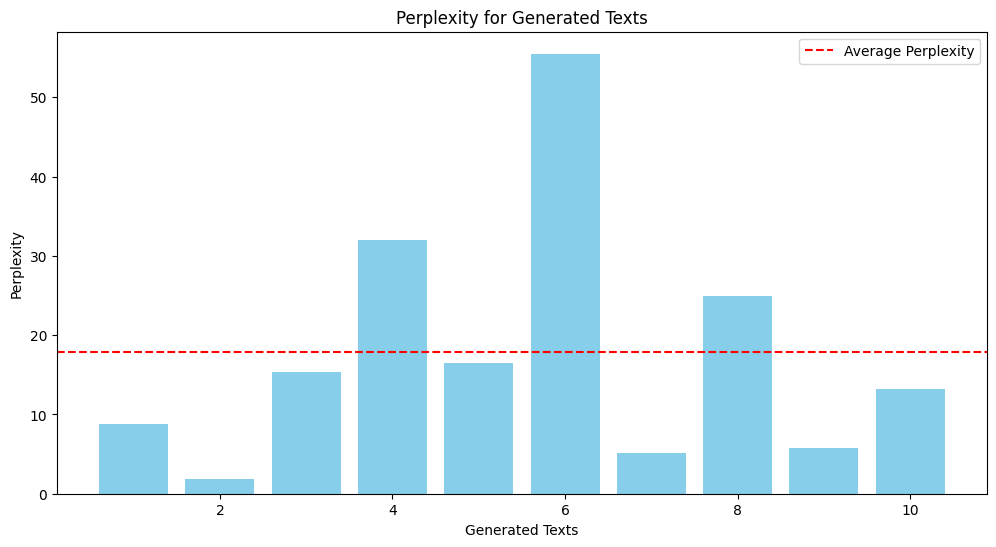

Average Perplexity: 17.912056514759833


In [340]:

GRU_pred= test_on_seed_texts(GRU_base,10,max_sequence_len-1,1.0) #generated text "normal" , temperature set as 1.0
model_path_GRU = "Models_RNN/GRU_base.h5" 

average_perplexity = analyze_and_plot_perplexity(GRU_pred, model_path_GRU, tokenizer, max_sequence_len)



### Results
- Based on the __plot__, we do see that the model yet again __stuggles__ to continue sequences mainly for __seed_text 6__, (let your time and energy...) having the __highest perplexity score of ~45__, followed by __seed_text 10__ (morning and evening)
- Average Perplexity of __17.91__ which is lower than that of __SimpleRNN__
- The __Perplexity score__ is quite reflective of the general __sentence flow as well__, as generated text for seed_text 2 (lowest score => better) tends to make more sense / easily readable compared to continuations of __seed_texts__ 6 and 10

In [205]:
for i,gen_text in enumerate(GRU_pred):
    print(f"{i+1}: {gen_text}")

1: embrace each day is a canvas for your journey and destiny for your
2: radiate some confidence, and let it be the bridge that fosters understanding
3: believe that our planet holds its strength and your dreams will take
4: life's actual purpose is where we learn to love unconditionally this morning holds its
5: dance through each and every moment of laughter is a chorus of joy in the
6: let your time and energy can mend hearts and restore faith is a step towards
7: every person is woven from threads of experience and learning richness that meaningful
8: our country Singapore is rich and vibrant stories of endurance and adaptation arms, embrace
9: planet earth is a canvas for your aspirations and dreams is a brushstroke,
10: morning and evening would make it is the most beautiful light shine so brightly that others


# Training LSTM Model


In [212]:
LSTM_base = Sequential()
LSTM_base.add(Embedding(input_dim=total_words, output_dim=128, input_length=max_sequence_len-1))
LSTM_base.add(GRU(units=64))
LSTM_base.add(Dropout(0.1))
LSTM_base.add(Dense(units=total_words, activation='softmax'))
LSTM_base.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history_LSTM_base = LSTM_base.fit(X_train,y_train,validation_data=(X_val,y_val), epochs=50,batch_size=128,verbose=1)

Epoch 1/50
431/431 [==============================] - 5s 8ms/step - loss: 5.0931 - accuracy: 0.1316 - val_loss: 4.4074 - val_accuracy: 0.2144
Epoch 2/50
431/431 [==============================] - 3s 7ms/step - loss: 4.0386 - accuracy: 0.2706 - val_loss: 3.7372 - val_accuracy: 0.3218
Epoch 3/50
431/431 [==============================] - 3s 7ms/step - loss: 3.5165 - accuracy: 0.3563 - val_loss: 3.3608 - val_accuracy: 0.3893
Epoch 4/50
431/431 [==============================] - 3s 7ms/step - loss: 3.1891 - accuracy: 0.4116 - val_loss: 3.0947 - val_accuracy: 0.4294
Epoch 5/50
431/431 [==============================] - 3s 7ms/step - loss: 2.9514 - accuracy: 0.4508 - val_loss: 2.8969 - val_accuracy: 0.4591
Epoch 6/50
431/431 [==============================] - 3s 7ms/step - loss: 2.7664 - accuracy: 0.4818 - val_loss: 2.7287 - val_accuracy: 0.4902
Epoch 7/50
431/431 [==============================] - 3s 7ms/step - loss: 2.6104 - accuracy: 0.5106 - val_loss: 2.5908 - val_accuracy: 0.5167
Epoch 

## Train and Validaton Accuracies / Loss
- we do see quite a decrease in both __train and validation accuracies (0.72)__ for the LSTM model compared to the __GRU & SimpleRNN__

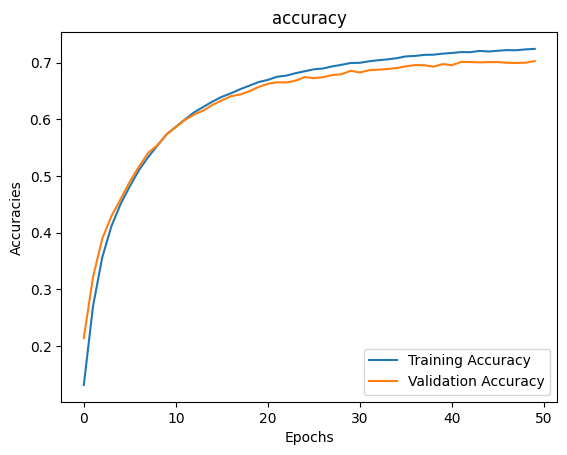

In [213]:
plot_graphs_acc(history_LSTM_base,'accuracy')

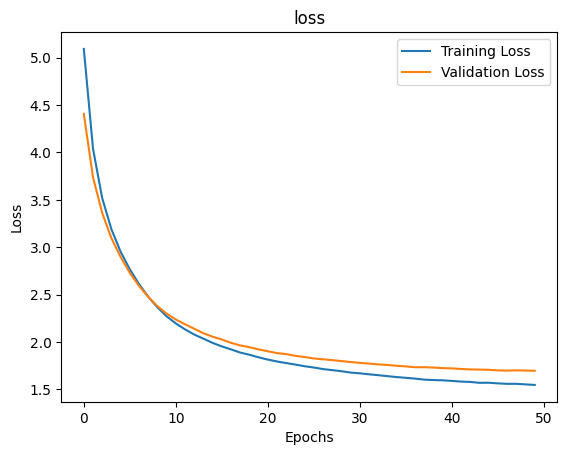

In [214]:
plot_graphs_loss(history_LSTM_base,'loss')

In [343]:
LSTM_pred_default = test_on_seed_texts(LSTM_base,10,33,1.0)
METEOR_score_gen_text(LSTM_pred_default, 'LSTM_pred_default')

LSTM_pred_default METEOR scores

METEOR Score for 'embrace each day': 0.124
METEOR Score for 'radiate some': 0.291
METEOR Score for 'believe that': 0.263
METEOR Score for 'life's actual purpose is': 0.358
METEOR Score for 'dance through each and every': 0.406
METEOR Score for 'let your time and energy': 0.19
METEOR Score for 'every person is': 0.282
METEOR Score for 'our country Singapore is': 0.153
METEOR Score for 'planet earth is': 0.089
METEOR Score for 'morning and evening would make it': 0.15

Overall METEOR Score for LSTM_pred_default: 0.231


# Training Bi-LSTM Model
- BiLSTM - every component of an input sequence has information from both the past and present which can produce a more meaningful output, combining LSTM layers from both directions.

In [ ]:

BiLSTM_base= Sequential()
BiLSTM_base.add(Embedding(total_words, 256, input_length=max_sequence_len-1))
BiLSTM_base.add(Bidirectional(LSTM(128)))
BiLSTM_base.add(Dropout(0.3))
BiLSTM_base.add(Dense(total_words, activation='softmax'))
BiLSTM_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
)
model_checkpoint_BiLSTM = ModelCheckpoint('Models_RNN/BiLSTM_base.h5',save_best_only=True)

history_BiLSTM_base = BiLSTM_base.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,batch_size=128,verbose=1,callbacks=[early_stopping,model_checkpoint_BiLSTM])
#print 
print(BiLSTM_base)

Epoch 1/50
431/431 [==============================] - 9s 14ms/step - loss: 5.0015 - accuracy: 0.1611 - val_loss: 4.2067 - val_accuracy: 0.2535
Epoch 2/50
431/431 [==============================] - 5s 12ms/step - loss: 3.8241 - accuracy: 0.3118 - val_loss: 3.4291 - val_accuracy: 0.3566
Epoch 3/50
431/431 [==============================] - 5s 12ms/step - loss: 3.1894 - accuracy: 0.3850 - val_loss: 2.9061 - val_accuracy: 0.4201
Epoch 4/50
431/431 [==============================] - 5s 13ms/step - loss: 2.7454 - accuracy: 0.4395 - val_loss: 2.5237 - val_accuracy: 0.4762
Epoch 5/50
431/431 [==============================] - 5s 12ms/step - loss: 2.4116 - accuracy: 0.4867 - val_loss: 2.2347 - val_accuracy: 0.5099
Epoch 6/50
431/431 [==============================] - 6s 13ms/step - loss: 2.1703 - accuracy: 0.5212 - val_loss: 2.0195 - val_accuracy: 0.5496
Epoch 7/50
431/431 [==============================] - 6s 13ms/step - loss: 1.9783 - accuracy: 0.5504 - val_loss: 1.8507 - val_accuracy: 0.5797

In [ ]:
BiLSTM_base.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 33, 256)           354304    
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_36 (Dense)            (None, 1384)              355688    
                                                                 
Total params: 1,104,232
Trainable params: 1,104,232
Non-trainable params: 0
_________________________________________________________________


## Looking at Train & Validation accuracies

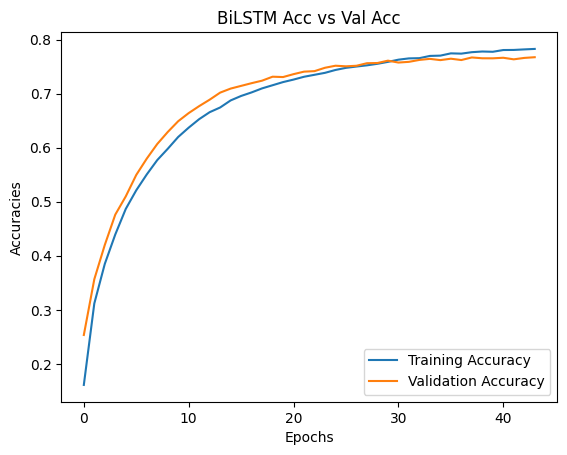

In [ ]:
plot_graphs_acc(history_BiLSTM_base,'BiLSTM Acc vs Val Acc')

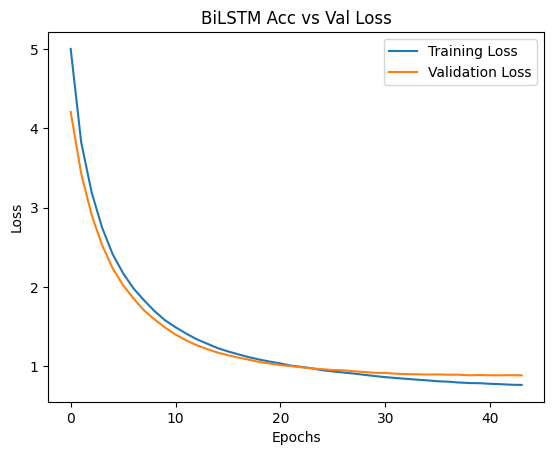

In [ ]:
plot_graphs_loss(history_BiLSTM_base,'BiLSTM Acc vs Val Loss')

## Evaluate Model on seed text 



In [356]:
BiLSTM_base = load_model("Models_RNN\BiLSTM_base.h5")

In [347]:
BiLSTM_base_precise = test_on_seed_texts(BiLSTM_base,10,max_sequence_len-1,0.2)

BiLSTM_base_creative = test_on_seed_texts(BiLSTM_base,10,max_sequence_len-1,1.2)



In [348]:
BiLSTM_base_precise 

['embrace each day is a precious gift you can give to another and',
 'radiate some enthusiasm, and watch how it ignites the world around you',
 'believe that you will conquer any challenge faced is a symphony of',
 "life's actual purpose is a testament to the goodness in your heart and soul",
 'dance through each and every day is a canvas for new beginnings and fresh opportunities',
 'let your time and energy is a testament to the strength and resilience of our',
 'every person is a step towards a joyful heart the heart of our',
 'our country Singapore is a sanctuary of life for our planet holds a life',
 "planet earth is a testament to the resilience of our planet's lifeforms of",
 'morning and evening would make it brings life to the seeds of your dreams and aspirations']

In [349]:
BiLSTM_base_creative

['embrace each day is your canvas, paint it well lived life well lived',
 'radiate some curiosity, for it is the courage to the power and',
 'believe that propels you forward is a gem, a treasure in the',
 "life's actual purpose is a leap of faith is a step towards witnessing, witnessing",
 'dance through each and every day brings new opportunities to shine so brightly that others',
 'let your time and energy to inspire and uplift shape your reality and influence your',
 'every person is a symphony of compassion and love that resonates in the',
 'our country Singapore is a gateway to your for growth and passion and dedication',
 'planet earth is a testament to the goodness in your soul of life',
 'morning and evening would make it is a canvas of your destiny, paint it with intention']

## Readibility Scores
_this is just a rough estimate, not fully accurate_

In [350]:
readability_score(BiLSTM_base_precise)

Text: embrace each day is a precious gift you can give to another and
Reading score: 83.66
Reading Difficulty: Easy

Text: radiate some enthusiasm, and watch how it ignites the world around you
Reading score: 67.76
Reading Difficulty: Standard

Text: believe that you will conquer any challenge faced is a symphony of
Reading score: 76.22
Reading Difficulty: Fairly Easy

Text: life's actual purpose is a testament to the goodness in your heart and soul
Reading score: 74.19
Reading Difficulty: Fairly Easy

Text: dance through each and every day is a canvas for new beginnings and fresh opportunities
Reading score: 64.71
Reading Difficulty: Standard

Text: let your time and energy is a testament to the strength and resilience of our
Reading score: 81.63
Reading Difficulty: Easy

Text: every person is a step towards a joyful heart the heart of our
Reading score: 83.66
Reading Difficulty: Easy

Text: our country Singapore is a sanctuary of life for our planet holds a life
Reading score: 74.19


In [351]:
readability_score(BiLSTM_base_creative)

Text: embrace each day is your canvas, paint it well lived life well lived
Reading score: 92.12
Reading Difficulty: Very Easy

Text: radiate some curiosity, for it is the courage to the power and
Reading score: 67.76
Reading Difficulty: Standard

Text: believe that propels you forward is a gem, a treasure in the
Reading score: 84.68
Reading Difficulty: Easy

Text: life's actual purpose is a leap of faith is a step towards witnessing, witnessing
Reading score: 57.27
Reading Difficulty: Fairly Difficult

Text: dance through each and every day brings new opportunities to shine so brightly that others
Reading score: 64.71
Reading Difficulty: Standard

Text: let your time and energy to inspire and uplift shape your reality and influence your
Reading score: 56.25
Reading Difficulty: Fairly Difficult

Text: every person is a symphony of compassion and love that resonates in the
Reading score: 66.74
Reading Difficulty: Standard

Text: our country Singapore is a gateway to your for growth and p

## Using METEOR score to evaluate generated sequence

In [352]:

METEOR_score_gen_text(BiLSTM_base_creative, 'BiLSTM_base_creative')
print("")
METEOR_score_gen_text(BiLSTM_base_precise, 'BiLSTM_base_precise')


BiLSTM_base_creative METEOR scores

METEOR Score for 'embrace each day': 0.179
METEOR Score for 'radiate some': 0.551
METEOR Score for 'believe that': 0.355
METEOR Score for 'life's actual purpose is': 0.329


METEOR Score for 'dance through each and every': 0.357
METEOR Score for 'let your time and energy': 0.208
METEOR Score for 'every person is': 0.556
METEOR Score for 'our country Singapore is': 0.342
METEOR Score for 'planet earth is': 0.453
METEOR Score for 'morning and evening would make it': 0.321

Overall METEOR Score for BiLSTM_base_creative: 0.365

BiLSTM_base_precise METEOR scores

METEOR Score for 'embrace each day': 0.454
METEOR Score for 'radiate some': 0.897
METEOR Score for 'believe that': 0.52
METEOR Score for 'life's actual purpose is': 0.521
METEOR Score for 'dance through each and every': 0.425
METEOR Score for 'let your time and energy': 0.586
METEOR Score for 'every person is': 0.695
METEOR Score for 'our country Singapore is': 0.226
METEOR Score for 'planet earth is': 0.696
METEOR Score for 'morning and evening would make it': 0.321

Overall METEOR Score for BiLSTM_base_precise: 0.534


## Perplexity Of Bi-LSTM Model



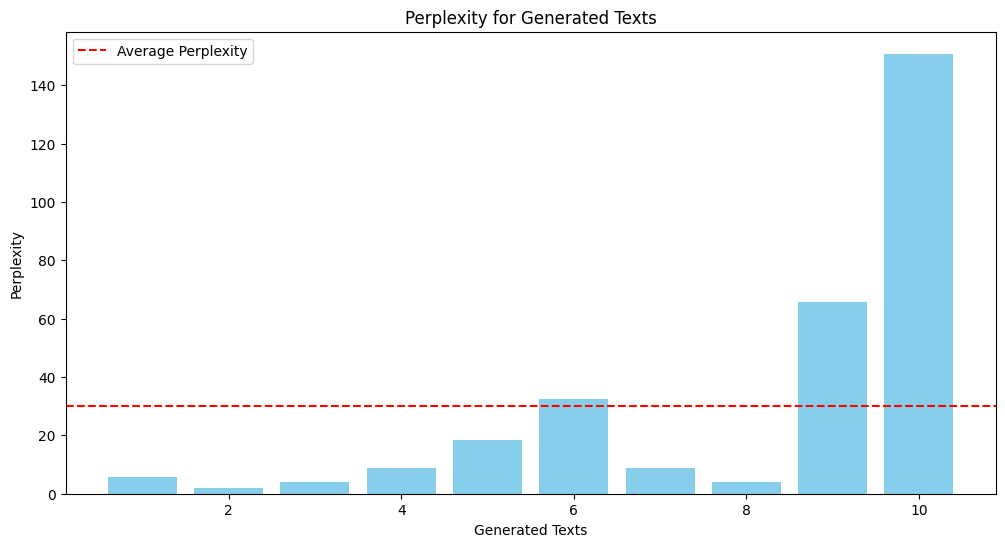

Average Perplexity: 30.054151782118037


In [358]:

BiLSTM_pred= test_on_seed_texts(BiLSTM_base,10,max_sequence_len-1,1.0) #generated text "normal" , temperature set as 1.0
model_path_BiLSTM = "Models_RNN/BiLSTM_base.h5" 

average_perplexity = analyze_and_plot_perplexity(BiLSTM_pred, model_path_BiLSTM, tokenizer, max_sequence_len)



### Results
- Based on the __plot__, we do see that the model __stuggles__ to continue sequences mainly for __seed_text 10__, (let your time and energy...) having the __highest perplexity score of ~140__
- Average Perplexity of __30.05__ which is bigger than that of __SimpleRNN__ but worse than __GRU__ 
- The __Perplexity score__ is quite reflective of the general __sentence flow as well__, as generated text for seed_text 2 (lowest score => better) tends to make more sense / easily readable compared to continuations of __seed_texts__ 9 and 10

In [359]:
for i,gen_text in enumerate(BiLSTM_pred):
    print(f"{i+1}: {gen_text}")

1: embrace each day is a reminder of the brilliance of light in the
2: radiate some determination, and let it be the guiding star of your
3: believe that this morning offers the promise of a fresh start and
4: life's actual purpose is a leap of faith is a step towards miracles of
5: dance through each and every dream nurtured with acts of kindness and love without words
6: let your time and energy is a brushstroke on the canvas of your destiny soar
7: every person is a classroom where we learn to love for it is
8: our country Singapore is a symphony of laughter and joy will follow a path
9: planet earth is a testament to its ambition and embraces diversity is a
10: morning and evening would make it will conquer any challenge overcome any challenge gentle gifts we


# Improving BiLSTM


### Learning Rate Decay
- Allows __Learning Rate__ of model to __decay over iterations__

In [360]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

### Fitting Model 
- Here we try two different Optimizers, __RMSprop,Adam & SGD__ with Learning rate decay

<!-- - We can observe that __RMSprop__ actually gave us a better train acc while overfitting more compared to __Adam__ -->

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop,Adagrad


# Define the optimizers to test along with their learning rates
optimizers = {'adam': Adam(learning_rate=lr_scheduler),'SGD': SGD(learning_rate=lr_scheduler), 'rmsprop': RMSprop(learning_rate=lr_scheduler)}

all_histories = {}

for optimizer_name, optimizer in optimizers.items():

    Model1 = Sequential()
    Model1.add(Embedding(total_words, 256, input_length=max_sequence_len-1))
    Model1.add(Bidirectional(LSTM(128)))
    Model1.add(Dropout(0.3))
    Model1.add(Dense(total_words, activation='softmax'))
    
    # Compile the model with the current optimizer
    Model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=5,
    )

    model_checkpoint_Model1 = ModelCheckpoint(f'Models_RNN/Model1_{optimizer_name}.h5', save_best_only=True)

    history_Model1 = Model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=256, verbose=1, callbacks=[early_stopping, model_checkpoint_Model1])

    all_histories[optimizer_name] = history_Model1.history

    Model1.summary()



Epoch 1/50
216/216 [==============================] - 7s 19ms/step - loss: 5.3142 - accuracy: 0.1196 - val_loss: 4.6354 - val_accuracy: 0.1902
Epoch 2/50
216/216 [==============================] - 3s 16ms/step - loss: 4.2710 - accuracy: 0.2532 - val_loss: 3.9169 - val_accuracy: 0.3053
Epoch 3/50
216/216 [==============================] - 3s 15ms/step - loss: 3.7151 - accuracy: 0.3296 - val_loss: 3.4694 - val_accuracy: 0.3562
Epoch 4/50
216/216 [==============================] - 3s 16ms/step - loss: 3.3302 - accuracy: 0.3685 - val_loss: 3.1328 - val_accuracy: 0.3890
Epoch 5/50
216/216 [==============================] - 3s 16ms/step - loss: 3.0275 - accuracy: 0.4009 - val_loss: 2.8575 - val_accuracy: 0.4199
Epoch 6/50
216/216 [==============================] - 3s 15ms/step - loss: 2.7837 - accuracy: 0.4281 - val_loss: 2.6416 - val_accuracy: 0.4443
Epoch 7/50
216/216 [==============================] - 3s 14ms/step - loss: 2.5860 - accuracy: 0.4541 - val_loss: 2.4593 - val_accuracy: 0.4746

## Train and Validation Accuracies of each Optimizer
- We can observe that __SGD__ performs the worse, while both __RMSprop & Adam__ are quite similar, although __RMSprop__ tend to let model learn faster, but they tend to converge at a similar point
- Both __SGD & RMSprop__ ~77 % Accuracy

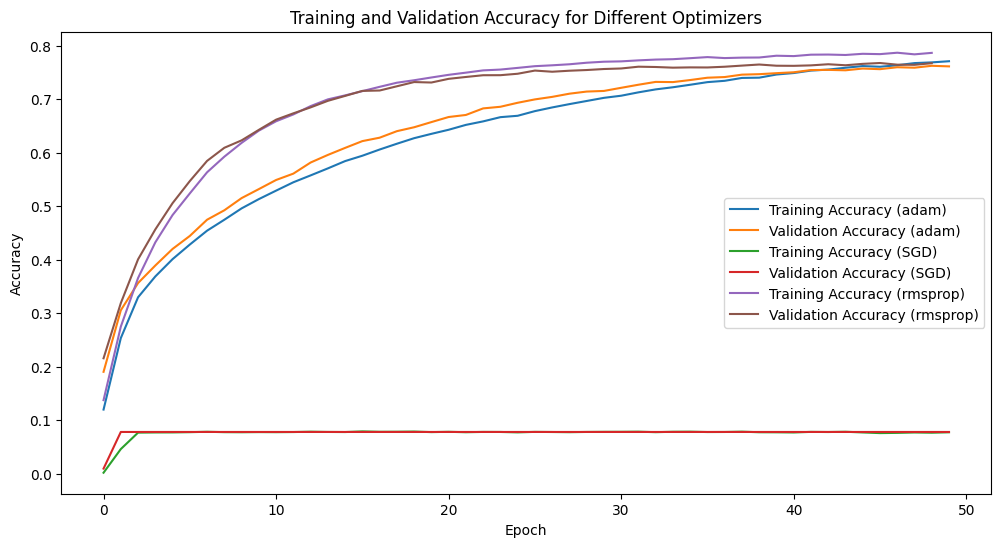

In [ ]:
# Plot the accuracies for each optimizer
plt.figure(figsize=(12, 6))

for optimizer_name, history in all_histories.items():
    plt.plot(history['accuracy'], label=f'Training Accuracy ({optimizer_name})')
    plt.plot(history['val_accuracy'], label=f'Validation Accuracy ({optimizer_name})')

plt.title('Training and Validation Accuracy for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loading Models

In [361]:
BiLSTM_rmsprop = load_model("Models_RNN\Model1_rmsprop.h5")
BiLSTM_adam = load_model("Models_RNN\Model1_adam.h5")

## Generating next 10 words
- we'll set __temperature__ to 1 , which should be the "default" 


In [362]:
BiLSTM_rmsprop = test_on_seed_texts(BiLSTM_rmsprop,10,max_sequence_len-1,1.0)

BiLSTM_adam  = test_on_seed_texts(BiLSTM_adam,10,max_sequence_len-1,1.0)



C:\Users\wilfr\AppData\Local\Temp\ipykernel_21416\1744082670.py:12: RuntimeWarning: divide by zero encountered in log
  prediction = np.log(prediction) / temperature


## Evaluating Generated texts

### Readbility of texts BiLSTM + RMSprop


In [363]:
readability_score(BiLSTM_rmsprop)

Text: embrace each day be the beacon of your soul and let your story
Reading score: 92.12
Reading Difficulty: Very Easy

Text: radiate some way forward is a testament to the beauty and resilience
Reading score: 59.3
Reading Difficulty: Invalid score

Text: believe that you are capable of conquering any obstacle that comes your
Reading score: 59.3
Reading Difficulty: Invalid score

Text: life's actual purpose is the melody of gratitude and a world of potential and
Reading score: 65.73
Reading Difficulty: Standard

Text: dance through each and every morning, let your actions be a testament to the goodness
Reading score: 73.17
Reading Difficulty: Fairly Easy

Text: let your time and energy of you will overcome any obstacle that comes your way
Reading score: 81.63
Reading Difficulty: Easy

Text: every person is a reminder of the earth's fiery heartbeat of you are
Reading score: 83.66
Reading Difficulty: Easy

Text: our country Singapore is a contented heart at peace in the heart to the
Rea

### Readbility of texts BiLSTM + Adam

In [364]:
readability_score(BiLSTM_adam)

Text: embrace each day is a canvas for new day filled with your true
Reading score: 92.12
Reading Difficulty: Very Easy

Text: radiate some gratitude, and watch how it transforms your world with joy
Reading score: 76.22
Reading Difficulty: Fairly Easy

Text: believe that the potential and possibilities that this morning offers the promise
Reading score: 42.38
Reading Difficulty: Difficult

Text: life's actual purpose is an investment in your future success on the world with
Reading score: 65.73
Reading Difficulty: Standard

Text: dance through each and every breath, let gratitude fill every corner of your journey and
Reading score: 73.17
Reading Difficulty: Fairly Easy

Text: let your time and energy is contagious and boundless peace in the fulfillment of your
Reading score: 64.71
Reading Difficulty: Standard

Text: every person is shape your reality and influence your world with brightness change
Reading score: 58.28
Reading Difficulty: Fairly Difficult

Text: our country Singapore is

### METEOR score
- Overall score wise, __RMSprop__ tends to do better

In [365]:

METEOR_score_gen_text(BiLSTM_rmsprop,'BiLSTM_rmsprop')


BiLSTM_rmsprop METEOR scores

METEOR Score for 'embrace each day': 0.525
METEOR Score for 'radiate some': 0.288
METEOR Score for 'believe that': 0.52
METEOR Score for 'life's actual purpose is': 0.449
METEOR Score for 'dance through each and every': 0.448
METEOR Score for 'let your time and energy': 0.387
METEOR Score for 'every person is': 0.728
METEOR Score for 'our country Singapore is': 0.332
METEOR Score for 'planet earth is': 0.184
METEOR Score for 'morning and evening would make it': 0.237

Overall METEOR Score for BiLSTM_rmsprop: 0.41


In [366]:

METEOR_score_gen_text(BiLSTM_adam,'BiLSTM_adam')


BiLSTM_adam METEOR scores

METEOR Score for 'embrace each day': 0.268
METEOR Score for 'radiate some': 0.605
METEOR Score for 'believe that': 0.161
METEOR Score for 'life's actual purpose is': 0.211
METEOR Score for 'dance through each and every': 0.425
METEOR Score for 'let your time and energy': 0.596
METEOR Score for 'every person is': 0.467
METEOR Score for 'our country Singapore is': 0.366
METEOR Score for 'planet earth is': 0.243
METEOR Score for 'morning and evening would make it': 0.232

Overall METEOR Score for BiLSTM_adam: 0.357


# Model Improvement

## Text Augmentation
- EDA (Easy Data Augmentation) 


Link: https://github.com/dsfsi/textaugment/blob/master/examples/eda_example.ipynb


In [226]:
from textaugment import EDA

# Create an EDA object
eda = EDA()

# Your original text
text = "Your original text goes here."

# Apply synonym replacement
augmented_texts = eda.synonym_replacement(data[0])

# Display the original and augmented texts
print("Original Text:", text)
print("Augmented Text:", augmented_texts)



Original Text: Your original text goes here.
Augmented Text: Embrace the beauty of every sunrise; it's a fresh chance to pigment your world with joy.


In [228]:

# Create an EDA object
eda = EDA()

# Your original text
text = "Your original text goes here."

# Apply random insertion
augmented_texts = eda.random_insertion(text)

# Display the original and augmented texts
print("Original Text:", text)
print("Augmented Text:", augmented_texts)

Original Text: Your original text goes here.
Augmented Text: Your original text master copy goes here.


## Model Improvement with KerasTunner for BiLSTM
- here, we would mainly perfomr __RandomSearch__ on:
    - __Optimizers__: Adam & RMSprop
    - __Dropout Rate__: [0.1,0.2,0.3,0.4,0.5]
    - __Learning Rate__ : [0.005,0.001,0.005,0.0005,0.0008]
    - __No. of BiLSTM Layers__: max 3 layers, min 1 layer
    - __Nodes__

In [122]:
# Function to build the model based on hyperparameters
def build_model_BiLSTM(hp):
    model = Sequential()
    model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))

    # Add BiLSTM layers based on the hyperparameter choice
    num_bilstm_layers = hp.Int('num_bilstm_layers', min_value=0, max_value=2, default=0)
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)

    for _ in range(num_bilstm_layers):
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
        model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # If num_bilstm_layers is 0, add a single LSTM layer
    if num_bilstm_layers == 0:
        model.add(LSTM(lstm_units))
        
    else:
        # Add the last Bidirectional LSTM layer with half the units
        model.add(Bidirectional(LSTM(lstm_units // 2)))

    #Final Dropout
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    # Add a Dense layer with softmax activation
    model.add(Dense(total_words, activation='softmax'))


    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[0.005,0.001,0.005,0.0005,0.0008])
    batch_size = hp.Int('batch_size', min_value=128, max_value=256, step=128)
    # Compile the model based on the hyperparameters
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model_BiLSTM,
    objective='val_accuracy',
    max_trials=10,  # Set the maximum number of trials
    directory='Models_RNN',
    project_name='hyperparameter_tuning_bilstm2',

)
model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Specify the file name for saving the best model
    save_best_only=True,
    monitor='val_loss',
    mode='min',  # 'min' if you are monitoring validation loss, 'max' for accuracy
    verbose=1
)
# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50,batch_size=128,validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])



Trial 10 Complete [00h 09m 03s]
val_accuracy: 0.7512513399124146

Best val_accuracy So Far: 0.7670656442642212
Total elapsed time: 01h 16m 30s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x00000207D9004AC0>
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 256)           354304    
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1384)              178536    
                                                                 
Total params: 729,960
Trainable params: 729,960
Non

### Looking at best hyperparameters

In [155]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Convert the HyperParameters object to a dictionary
best_hps_dict = best_hps.get_config()

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hps_dict)

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Best Hyperparameters:
{'space': [{'class_name': 'Int', 'config': {'name': 'num_bilstm_layers', 'default': 0, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'lstm_units', 'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'optimizer', 'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'default': 0.005, 'conditions': [], 'values': [0.005, 0.001, 0.005, 0.0005, 0.0008], 'ordered': True}}, {'class_name': 'Int', 'config': {'name': 'batch_size', 'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': 'linear'}}], 'values': 

### Retrain Model with best hyperparams

In [1]:
# Compile the model
best_model.compile(
    loss='categorical_crossentropy',
    optimizer=best_model.optimizer,  # Use the best optimizer from the tuner
    metrics=['accuracy']
)
best_model1 = ModelCheckpoint("Models_RNN/BiLSTM_tuned_1.h5")


history_best_model = best_model.fit(
    X_train,  
    y_train,  
    epochs=100,  # Set it higher just to see 
    batch_size=128,  
    validation_data=(X_val, y_val), 
    callbacks=[EarlyStopping(monitor='val_loss', patience=5),best_model1]
)

NameError: name 'best_model' is not defined

### Train and Validation accuracies

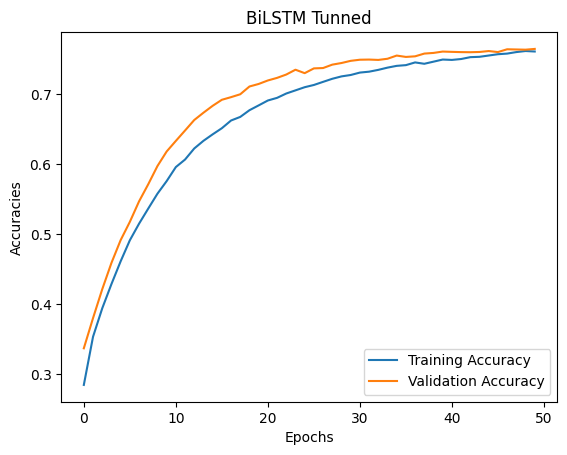

In [186]:
plot_graphs_acc(history_best_model,"BiLSTM Tunned")

### Load and Evaluate

In [377]:
best_model1 = load_model("Models_RNN/BiLSTM_tuned_1.h5")

In [368]:
best_model1_precise = test_on_seed_texts(best_model1,10,max_sequence_len-1,0.2)

C:\Users\wilfr\AppData\Local\Temp\ipykernel_21416\1744082670.py:12: RuntimeWarning: divide by zero encountered in log
  prediction = np.log(prediction) / temperature


In [369]:
readability_score(best_model1_precise)

Text: embrace each day brings new opportunities to shine brighter future of our planet
Reading score: 66.74
Reading Difficulty: Standard

Text: radiate some positivity, for it is the key to unlocking a bright
Reading score: 50.84
Reading Difficulty: Fairly Difficult

Text: believe that this morning offers the promise of a fresh start and
Reading score: 84.68
Reading Difficulty: Easy

Text: life's actual purpose is a reminder of the marvel, the marvel of existence and
Reading score: 57.27
Reading Difficulty: Fairly Difficult

Text: dance through each and every step we take forward is a victory on the universe
Reading score: 81.63
Reading Difficulty: Easy

Text: let your time and energy is a symphony of compassion and love and joy that
Reading score: 73.17
Reading Difficulty: Fairly Easy

Text: every person is a chapter in your story of your journey, a tale
Reading score: 75.2
Reading Difficulty: Fairly Easy

Text: our country Singapore is a door to a world of potential and possibility o

In [370]:
best_model1_creative = test_on_seed_texts(best_model1,10,max_sequence_len-1,1.5)

C:\Users\wilfr\AppData\Local\Temp\ipykernel_21416\1744082670.py:12: RuntimeWarning: divide by zero encountered in log
  prediction = np.log(prediction) / temperature


In [371]:
readability_score(best_model1_creative)

Text: embrace each day brings life to the soul of your soul of our
Reading score: 100.58
Reading Difficulty: Very Easy

Text: radiate some love, for it is the key to unlocking genuine connections
Reading score: 59.3
Reading Difficulty: Invalid score

Text: believe that this morning presents to you are not alone and transform
Reading score: 84.68
Reading Difficulty: Easy

Text: life's actual purpose is alive and thriving that life's light shine bright future for
Reading score: 74.19
Reading Difficulty: Fairly Easy

Text: dance through each and every day is the journey that resides within your soul free
Reading score: 81.63
Reading Difficulty: Easy

Text: let your time and energy is a tale worth telling is a sanctuary of a
Reading score: 81.63
Reading Difficulty: Easy

Text: every person is an gift to the journey we've traveled them with others
Reading score: 75.2
Reading Difficulty: Fairly Easy

Text: our country Singapore is a gateway to a brighter tomorrow and significant part of
Read

### Meteor Score

In [372]:
METEOR_score_gen_text(best_model1_precise,'best_model1_precise')

best_model1_precise METEOR scores

METEOR Score for 'embrace each day': 0.165
METEOR Score for 'radiate some': 0.661
METEOR Score for 'believe that': 0.18
METEOR Score for 'life's actual purpose is': 0.358
METEOR Score for 'dance through each and every': 0.391
METEOR Score for 'let your time and energy': 0.406
METEOR Score for 'every person is': 0.531
METEOR Score for 'our country Singapore is': 0.631
METEOR Score for 'planet earth is': 0.243
METEOR Score for 'morning and evening would make it': 0.264

Overall METEOR Score for best_model1_precise: 0.383


In [373]:
METEOR_score_gen_text(best_model1_creative,'best_model1_creative')

best_model1_creative METEOR scores

METEOR Score for 'embrace each day': 0.307
METEOR Score for 'radiate some': 0.661
METEOR Score for 'believe that': 0.275
METEOR Score for 'life's actual purpose is': 0.211
METEOR Score for 'dance through each and every': 0.391
METEOR Score for 'let your time and energy': 0.425
METEOR Score for 'every person is': 0.336
METEOR Score for 'our country Singapore is': 0.53
METEOR Score for 'planet earth is': 0.243
METEOR Score for 'morning and evening would make it': 0.39

Overall METEOR Score for best_model1_creative: 0.377


## Perplexity Of Bi-LSTM Model



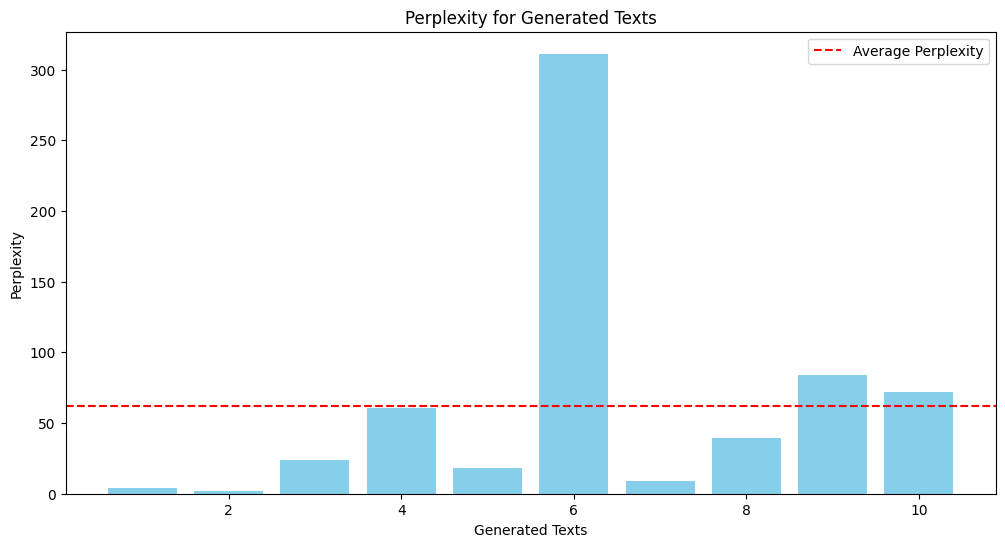

Average Perplexity: 62.29356440380874


In [378]:

BiLSTM_tuned_pred= test_on_seed_texts(BiLSTM_base,10,max_sequence_len-1,1.0) #generated text "normal" , temperature set as 1.0
model_path_BiLSTM_tuned = "Models_RNN/BiLSTM_tuned_1.h5" 

average_perplexity = analyze_and_plot_perplexity(BiLSTM_tuned_pred, model_path_BiLSTM_tuned, tokenizer, max_sequence_len)



### Results
- Based on the __plot__, we do see that the model __stuggles__ to continue sequences mainly for __seed_text 6__, (let your time and energy...) having the __highest perplexity score of ~300__
- Average Perplexity of __62.05__ 


In [379]:
for i,gen_text in enumerate(BiLSTM_tuned_pred):
    print(f"{i+1}: {gen_text}")

1: embrace each day is a precious jewel in the cosmos, deserves our utmost
2: radiate some confidence be the wind that propels you forward is a
3: believe that you will leave a love letter to the future of
4: life's actual purpose is a picture of the artistry of our planet holds a
5: dance through each and every step we take towards our dreams and dreams take flight
6: let your time and energy to hindhede nature park's serenity, singapore's nature is diverse and
7: every person is a step towards excellence and progress and innovation pave the
8: our country Singapore is a sanctuary of life story of your soul on the
9: planet earth is a canvas for new beginnings and fresh opportunities to happiness
10: morning and evening would make it is a beam of light in the world around you


## Model Improvement for Bi-GRU
- We can also use a __Bi-directional GRU__, similar to BiLSTM, which allows it to capture both __past and future__ input sequences, wherelse a regular GRU only has access to info from the past
- Tune using __KerasTunner__ build_model & __GridSearch__ 

<!-- The main difference between a GRU and a bi-GRU is that a bi-GRU has two separate hidden states, one for each direction, and it concatenates the final hidden states from both directions before making its final prediction. This allows the bi-GRU to capture information from both the past and the future of the input sequence, whereas a regular GRU only has access to information from the past. -->

In [58]:
# Function to build the model based on hyperparameters
def build_model_GRU(hp):
    model = Sequential()
    embedding_nodes = hp.Int('embedding_nodes', min_value=64, max_value=256, step=64)
    model.add(Embedding(total_words, embedding_nodes, input_length=max_sequence_len-1))

    # Add GRU layers based on the hyperparameter choice
    num_gru_layers = hp.Int('num_GRU_layers', min_value=0, max_value=2, default=0)
    gru_units = hp.Int('gru_units', min_value=64, max_value=256, step=32)

    for _ in range(num_gru_layers):
        model.add(Bidirectional(GRU(gru_units, return_sequences=True)))
        model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # If num_gru_layers is 0, add a single GRU layer
    if num_gru_layers == 0:
        model.add(GRU(gru_units))
        
    else:
        # Add the last Bidirectional GRU layer with half the units
        model.add(Bidirectional(GRU(gru_units // 2)))

    # Final Dropout
    model.add(Dropout(hp.Float('final_dropout', min_value=0.1, max_value=0.5, step=0.1)))
    # Add a Dense layer with softmax activation
    model.add(Dense(total_words, activation='softmax'))

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[0.005, 0.001, 0.0005, 0.0008])
    batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=64)

    # Compile the model based on the hyperparameters
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Instantiate the tuner
tuner = GridSearch(
    build_model_GRU,
    objective='val_accuracy',
    max_trials=20,
    directory='Models_RNN',
    project_name='grid_search_gru1',
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Specify the file name for saving the best model
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',  # 'min' if you are monitoring validation loss, 'max' for accuracy
    verbose=1
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_accuracy', patience=5), model_checkpoint],epochs=30)

Trial 20 Complete [00h 04m 15s]
val_accuracy: 0.5753355026245117

Best val_accuracy So Far: 0.7715632915496826
Total elapsed time: 01h 38m 40s


### Get Best Hyperparmeters

In [59]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Convert the HyperParameters object to a dictionary
best_hps_dict = best_hps.get_config()

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hps_dict)

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Best Hyperparameters:
{'space': [{'class_name': 'Int', 'config': {'name': 'num_GRU_layers', 'default': 0, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'gru_units', 'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'final_dropout', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'optimizer', 'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'default': 0.005, 'conditions': [], 'values': [0.005, 0.001, 0.0005, 0.0008], 'ordered': True}}, {'class_name': 'Int', 'config': {'name': 'batch_size', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 64, 'sampling': 'linear'}}], 'values': {'num_G

### Compile & Train

In [60]:
# Compile the model
best_model.compile(
    loss='categorical_crossentropy',
    optimizer=best_model.optimizer,  # Use the best optimizer from the tuner
    metrics=['accuracy']
)
best_model2 = ModelCheckpoint("Models_RNN/BiGRU_tuned_1.h5")


history_best_model = best_model.fit(
    X_train,  
    y_train,  
    epochs=100,  # Set it higher just to see 
    batch_size=128,  
    validation_data=(X_val, y_val), 
    callbacks=[EarlyStopping(monitor='val_loss', patience=5),best_model2]
)

Epoch 1/100
431/431 [==============================] - 5s 8ms/step - loss: 5.3800 - accuracy: 0.1043 - val_loss: 4.6670 - val_accuracy: 0.1816
Epoch 2/100
431/431 [==============================] - 3s 7ms/step - loss: 4.0517 - accuracy: 0.2790 - val_loss: 3.5150 - val_accuracy: 0.3505
Epoch 3/100
431/431 [==============================] - 3s 7ms/step - loss: 3.1515 - accuracy: 0.3977 - val_loss: 2.8326 - val_accuracy: 0.4416
Epoch 4/100
431/431 [==============================] - 3s 7ms/step - loss: 2.5620 - accuracy: 0.4789 - val_loss: 2.3645 - val_accuracy: 0.5068
Epoch 5/100
431/431 [==============================] - 3s 7ms/step - loss: 2.1539 - accuracy: 0.5420 - val_loss: 2.0286 - val_accuracy: 0.5647
Epoch 6/100
431/431 [==============================] - 3s 7ms/step - loss: 1.8587 - accuracy: 0.5916 - val_loss: 1.7872 - val_accuracy: 0.6141
Epoch 7/100
431/431 [==============================] - 3s 7ms/step - loss: 1.6469 - accuracy: 0.6301 - val_loss: 1.6129 - val_accuracy: 0.6394

### Looking at Train and Val accuracies

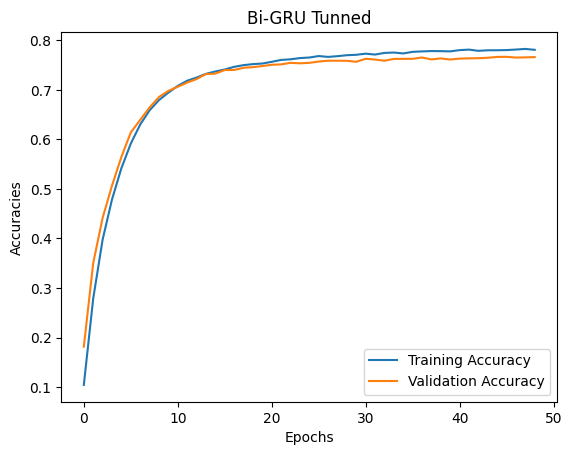

In [101]:
plot_graphs_acc(history_best_model,"Bi-GRU Tunned")

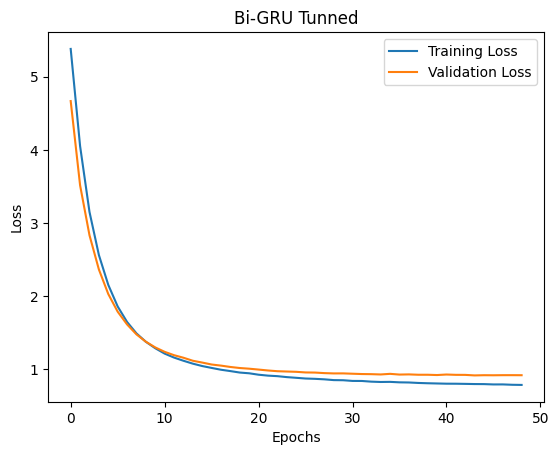

In [85]:
plot_graphs_loss(history_best_model,"Bi-GRU Tunned")

### Load and Evaluate

In [113]:
best_model2 = load_model("Models_RNN/BiGRU_tuned_1.h5")

In [114]:
best_model2_precise = test_on_seed_texts(best_model2,10,max_sequence_len-1,0.2)


In [115]:
readability_score(best_model2_precise)

Text: embrace each day with strength and influence your world transform around you will
Reading score: 83.66
Reading Difficulty: Easy

Text: radiate some confidence, and let it be the foundation of your greatness
Reading score: 59.3
Reading Difficulty: Invalid score

Text: believe that propels you forward is a victory on the path to
Reading score: 76.22
Reading Difficulty: Fairly Easy

Text: life's actual purpose is alive and thriving learning determination shape destinies destinies ubin's heritage,
Reading score: 31.89
Reading Difficulty: Difficult

Text: dance through each and every moment is a chance for adventure is the pursuit of
Reading score: 81.63
Reading Difficulty: Easy

Text: let your time and energy will conquer anything brings new beginnings and fresh opportunities that
Reading score: 47.79
Reading Difficulty: Difficult

Text: every person is the wide open canvases of nature's palette palette no longer
Reading score: 66.74
Reading Difficulty: Standard

Text: our country Si

In [116]:
best_model2_creative = test_on_seed_texts(best_model2,10,max_sequence_len-1,1.5)

In [117]:
readability_score(best_model2_creative)

Text: embrace each day with a heart full of positive affirmations; they are the
Reading score: 66.74
Reading Difficulty: Standard

Text: radiate some confidence, and let it be the armor that shields your
Reading score: 76.22
Reading Difficulty: Fairly Easy

Text: believe that holds the potential, the potential to success a sanctuary of
Reading score: 50.84
Reading Difficulty: Fairly Difficult

Text: life's actual purpose is alive and fostering understanding and compassion that reside within you
Reading score: 31.89
Reading Difficulty: Difficult

Text: dance through each and every sand gem, a logic for opportunities ubin's presents to forgiveness
Reading score: 64.71
Reading Difficulty: Standard

Text: let your time and energy carry seasons, embracing vulnerability, for it waters the seeds that
Reading score: 39.33
Reading Difficulty: Difficult

Text: every person is our souls barriers artistry of elders, for unveil the brilliance
Reading score: 66.74
Reading Difficulty: Standard

Text:

### Meteor Score

In [382]:
METEOR_score_gen_text(best_model2_precise,'best_model2_precise')

best_model2_precise METEOR scores

METEOR Score for 'embrace each day': 0.282
METEOR Score for 'radiate some': 0.897
METEOR Score for 'believe that': 0.402
METEOR Score for 'life's actual purpose is': 0.211
METEOR Score for 'dance through each and every': 0.487
METEOR Score for 'let your time and energy': 0.301
METEOR Score for 'every person is': 0.248
METEOR Score for 'our country Singapore is': 0.158
METEOR Score for 'planet earth is': 0.4
METEOR Score for 'morning and evening would make it': 0.255

Overall METEOR Score for best_model2_precise: 0.364


In [383]:
METEOR_score_gen_text(best_model2_creative,'best_model2_creative')

best_model2_creative METEOR scores

METEOR Score for 'embrace each day': 0.556
METEOR Score for 'radiate some': 0.914
METEOR Score for 'believe that': 0.437
METEOR Score for 'life's actual purpose is': 0.211
METEOR Score for 'dance through each and every': 0.357
METEOR Score for 'let your time and energy': 0.363
METEOR Score for 'every person is': 0.248
METEOR Score for 'our country Singapore is': 0.195
METEOR Score for 'planet earth is': 0.27
METEOR Score for 'morning and evening would make it': 0.255

Overall METEOR Score for best_model2_creative: 0.38


## Perplexity Of Bi-GRU Model



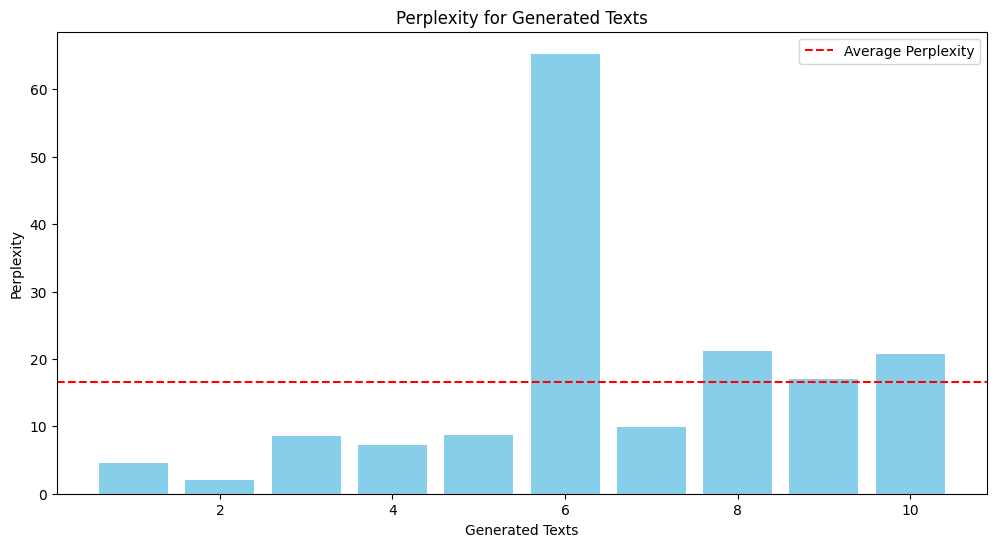

Average Perplexity: 16.508635345078652


In [380]:

BiGRU_pred= test_on_seed_texts(best_model2,10,max_sequence_len-1,1.0) #generated text "normal" , temperature set as 1.0
model_path_BiGRU = "Models_RNN/BiGRU_tuned_1.h5" 

average_perplexity = analyze_and_plot_perplexity(BiGRU_pred, model_path_BiGRU, tokenizer, max_sequence_len)



### Results
- Based on the __plot__, we do see that the model __stuggles__ to continue sequences mainly for __seed_text 6__, (let your time and energy...) having the __highest perplexity score of ~65__
- Average Perplexity of __16.50__ which is lowest so far, however this doesn't imply overall model prediction ability is the best
- The __Perplexity score__ is quite reflective of the general __sentence flow as well__, as generated text for seed_text 2 (lowest score => better) tends to make more sense / easily readable compared to continuations of __seed_texts__ 6

In [381]:
for i,gen_text in enumerate(BiGRU_pred):
    print(f"{i+1}: {gen_text}")

1: embrace each day with modernity in the ordinary; it's the heartbeat of a
2: radiate some enthusiasm, and let it be the chorus of your life's
3: believe that propels you forward is a gesture of hope for it
4: life's actual purpose is alive and thriving refreshment and renewal resilient version of yourself
5: dance through each and every moment is a classroom where we learn to love unconditionally
6: let your time and energy ripples out, creating abundance around you leave behind a precious
7: every person is our souls, transcending differences, and fostering understanding and compassion that
8: our country Singapore is today nation's aspirations and dreams will take flight of generosity
9: planet earth is a gift from the perfume of our planet's beauty is
10: morning and evening would make it knows no limits the blessings of your heart be the
